# Discussion 02

## k-means and RBF Features

Welcome to Discussion 02. In this discussion, we'll get more practice with k-means and radial basis functions for classification in the context of image recognition.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster

The following cell will download the MNIST digit dataset:

In [ ]:
%%bash
if [[ ! -e "mnist.npz" ]]; then
    wget 'https://f000.backblazeb2.com/file/jeldridge-data/mnist.npz'
fi

In [2]:
mnist = np.load('mnist.npz')

### Problem 01. Let's give ourselves the problem of predicting whether a given image is a three or not a three. Note that this is harder than the problem of, e.g., predicting 3 vs. 7, because all of the digits will be included in the data set.

First, let's curate a training and test set. We'll balance it so that there are equally as many threes as non-threes.

In [3]:
def retrieve_data(features, labels):
    threes = features[labels == 3]
    non_threes = features[labels != 3]
    ix = np.random.choice(len(non_threes), size=len(threes))
    
    X = np.vstack((threes, non_threes[ix]))
    y = np.concatenate([
        np.ones(len(threes)),
        -np.ones(len(threes))
    ])
    return X, y

In [4]:
X_train, y_train = retrieve_data(mnist['train'].T, mnist['train_labels'].flat)
X_test, y_test = retrieve_data(mnist['test'].T, mnist['test_labels'].flat)

Here's a helpful function for visualizing an image:

In [5]:
def show_digit(v):
    plt.imshow(v.reshape((28, -1)))

You can use it as follows:

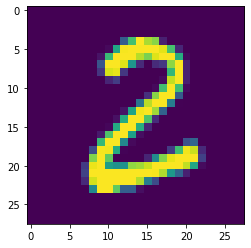

In [6]:
show_digit(X_train[7000])

Lastly, here's a helper function to augment a data matrix:

In [ ]:
def augment(X):
    return np.column_stack((
        np.ones(len(X)),
        X
    ))

In [7]:
# visualizing 28x28 pixel values in numerical form
n = 7000
for i in range(28):
    for j in range(28):
        print(f'{X_train[n][28*i+j]:03}', end=' ')
    print()

000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 
000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 
000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 
000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 
000 000 000 000 000 000 000 000 000 000 000 000 075 180 255 223 210 022 000 000 000 000 000 000 000 000 000 000 
000 000 000 000 000 000 000 000 000 000 006 152 252 254 254 254 254 245 181 027 000 000 000 000 000 000 000 000 
000 000 000 000 000 000 000 000 000 013 174 254 254 254 228 204 243 254 254 159 005 000 000 000 000 000 000 000 
000 000 000 000 000 000 000 000 000 067 254 254 244 134 030 000 031 041 212 254 022 000 000 000 000 000 000 000 
000 000 000 000 000 000 000 000 000 039 240 246 041 000 000 000 000 000 169 254 022 000 000 000 

**Question 01.** Let's warm up by just trying a simple least squares classifier. What is the test accuracy of a least squares classifier trained on this data?

In [ ]:
# BEGIN SOLUTION
w = np.linalg.lstsq(augment(X_train), y_train)[0]
y_pred = augment(X_test) @ w
(np.sign(y_pred) == y_test).mean()
# END SOLUTION

**Question 02**. Perform k-means clustering and find 100 cluster centers in the training data. Plot a few of the cluster centers using `show_digit` to see what they look like.

In [ ]:
# BEGIN SOLUTION
kmeans = sklearn.cluster.KMeans(n_clusters=100)
kmeans.fit(X_train)
show_digit(kmeans.cluster_centers_[50])
# END SOLUTION

In [ ]:
# Visualize first 10 centers
for i in range(10):
    show_digit(kmeans.cluster_centers_[i])
    plt.show()

**Question 03**. Below is a function which makes a Gaussian RBF given a center $\mu$ and a value of $\sigma$:

In [ ]:
def make_rbf(mu, sigma):
    def rbf(x):
        return np.exp(-np.linalg.norm(x - mu, axis=1)**2 / sigma**2)
    return rbf

def rbf_feature(x, mu, sigma):
    return np.exp(-np.linalg.norm(x - mu, axis=1)**2 / sigma**2)

In particular, the function that is created will take in an entire data matrix, $X$, and return an array of the new feature for each data point.

Using the k-means cluster centers, create an $n \times 100$ array `X_phi_train` containing the new RBF features. Choose $\sigma$ to be something you think is reasonable -- use the same $\sigma$ for each RBF.

In [ ]:
# BEGIN SOLUTION
rbfs = [make_rbf(mu, 1000) for mu in kmeans.cluster_centers_]
X_phi_train = np.column_stack([rbf(X_train) for rbf in rbfs])
# END SOLUTION

**Question 04**. Following the same procedure, create the array `X_phi_test` which contains the features for the test data mapped to the same representation using the RBFs.

In [ ]:
X_phi_test = np.column_stack([rbf(X_test) for rbf in rbfs]) # SOLUTION

**Question 05**. What is the test accuracy of a least squares classifier training on your new features?

*Hint*: You should be able to do better than the least squares classifier we trained before, but *only* if you choose $\sigma$ correctly. Try a few different values.

In [ ]:
# BEGIN SOLUTION
w = np.linalg.lstsq(augment(X_phi_train), y_train)[0]
y_pred = augment(X_phi_test) @ w
(np.sign(y_pred) == y_test).mean()
# END SOLUTION

**Extra Question**. In practice, we don't choose $\sigma$ by hand. Instead, we use a separate *validation* data set to test the accuracy obtained by using a variety of $\sigma$ and keep the one that returns the best performance. Note that we shouldn't pick the $\sigma$ that gives us the best result on the test set, because that is cheating!

The code below splits our training set into a new training set and a validation set.

In [ ]:
X_train, X_validation, y_train, y_validation = sklearn.model_selection.train_test_split(
    X_train, y_train, test_size=0.25
)

Find a value of $\sigma$ which gives the best accuracy on the validation set by looping over possible $\sigma$ within a reasonable range of possible values.

In [ ]:
# BEGIN SOLUTION
def validation_accuracy(sigma):
    rbfs = [make_rbf(mu, sigma) for mu in kmeans.cluster_centers_]
    X_phi_train = np.column_stack([rbf(X_train) for rbf in rbfs])
    X_phi_validation = np.column_stack([rbf(X_validation) for rbf in rbfs])
    w = np.linalg.lstsq(augment(X_phi_train), y_train)[0]
    y_pred = augment(X_phi_validation) @ w
    return (np.sign(y_pred) == y_validation).mean()

accs = [(sigma, validation_accuracy(sigma)) for sigma in np.linspace(500, 5000, 20)]
accs
# END SOLUTION

### **Problem 02**. Consider the data set below:

In [ ]:
import sklearn.datasets
np.random.seed(42)
X_moons, y_moons = sklearn.datasets.make_moons(200, noise=.1)
y_moons = (y_moons - .5) * 2

plt.scatter(*X_moons.T, c=y_moons)

Here, `X_moons` represents a training set of points in $\mathbb R^2$, containing one data point per row. `y_moons` contains the label of each training point.

Design four basis functions, $\varphi_1, \ldots, \varphi_4$ for transforming this data into a new representation in $\mathbb R^4$ where binary classification becomes "easy". Your functions should take in the entire data matrix, `X`, and return an array containing the new feature for each training point.

Your basis functions will be evaluated by training a least squares classifier on the augmented new features. To receive full credit, your new representation should be good enough that the classifier has a training accuracy of at least 90%.

In [ ]:
# BEGIN SOLUTION
def phi_1(X):
    return np.exp(-np.sum((X - [0, -.5])**2, axis=1))

def phi_2(X):
    return np.exp(-np.sum((X - [2, -.5])**2, axis=1))

def phi_3(X):
    return np.exp(-np.sum((X - [-1, 1.25])**2, axis=1))

def phi_4(X):
    return np.exp(-np.sum((X - [1, 1.25])**2, axis=1))

Phi = np.column_stack((
    np.ones(len(X_moons)),
    phi_1(X_moons),
    phi_2(X_moons),
    phi_3(X_moons),
    phi_4(X_moons)
))
w = np.linalg.solve(Phi.T @ Phi, Phi.T @ y_moons)
(np.sign(Phi @ w) == y_moons).mean()


# Visualize 2 components of the data in the new representation
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# transformed = pca.fit_transform(Phi)
# plt.scatter(*transformed.T, c=y_moons)

# END SOLUTION